In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../utils'))
from ae_torch_classes import *
from subspace_clustering_helper_funcs import *
from data_loading_paths import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [21]:
#from utils.data_loading_paths import *

kai_laptop = False
brc_desktop = True

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

#combined_emg_pca8_df = pd.read_pickle(data_path+emg_pca8_dir+'$BStand_EMG_PCA8_df.pkl')
PCA_df = pd.read_pickle(data_path+emg_pca8_dir+'$BStand_EMG_PCA8_df.pkl')
unstand_emg_df = pd.read_pickle(data_path+'filtered_datasets\\metadata_EMG_allgestures_allusers.pkl')


In [22]:
print(PCA_df.shape)
PCA_df.head()

(204800, 8)


,0,1,2,3,4,5,6,7
0,-1.341323,-0.812209,0.089633,-0.231389,-1.102774,-0.123494,-0.452216,-0.563469
1,-0.644262,-0.860011,0.240803,-0.036121,-1.728382,-0.271787,-1.100263,0.143207
2,-1.251829,-0.823973,-0.213519,0.139521,-2.368628,-0.276726,-2.114243,0.468320
3,-1.494897,-0.633561,-0.233368,0.250943,-2.434067,-0.437012,-2.570415,0.370891
4,1.615750,-1.806795,-1.070433,-0.332640,-2.581807,-0.507581,-3.102347,0.600151


In [23]:
print(unstand_emg_df.shape)
unstand_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000004,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000005,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000004,0.000005,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.000002,0.000002,0.000002,0.000002,0.000005,0.000006,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.000003,0.000002,0.000002,0.000002,0.000005,0.000007,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


Let's actually re-arrange to make them 3D matrices...

In [24]:
num_rows_per_gesture = 64 # From the interp
num_gestures = len(PCA_df) // num_rows_per_gesture
num_features = PCA_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(PCA_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = PCA_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
PCA_np = data_np.reshape(num_gestures, num_rows_per_gesture, num_features)
#PCA_np = PCA_df.to_numpy()
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

In [25]:
PCA_np.shape

(3200, 64, 8)

In [26]:
PCA_df = pd.concat([metadata_cols_df, PCA_df], axis=1)
PCA_df.head()

,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,7
0,P102,pan,1,-1.341323,-0.812209,0.089633,-0.231389,-1.102774,-0.123494,-0.452216,-0.563469
1,P102,pan,1,-0.644262,-0.860011,0.240803,-0.036121,-1.728382,-0.271787,-1.100263,0.143207
2,P102,pan,1,-1.251829,-0.823973,-0.213519,0.139521,-2.368628,-0.276726,-2.114243,0.468320
3,P102,pan,1,-1.494897,-0.633561,-0.233368,0.250943,-2.434067,-0.437012,-2.570415,0.370891
4,P102,pan,1,1.615750,-1.806795,-1.070433,-0.332640,-2.581807,-0.507581,-3.102347,0.600151


## Hierarchy / Dendrogram
Now, let's investigate a more informed choice, based on measured statistical heterogenity. Could look at Shannon or KL divergence (heatmap), but I'll just look at a dendogram for now.

metric: The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
> How to choose one... equations are listed and briefely explained in the above docs. Implications/consequences are not covered tho

In [27]:
def calculate_distance(df1, df2, distance_metric='euclidean'):
    """
    Calculate the distance between two sets of gesture data.

    Parameters:
    - df1: DataFrame containing gesture data for the first user.
    - df2: DataFrame containing gesture data for the second user.
    - distance_metric: The distance metric to use. Default is 'euclidean'. Other options include 'cosine', 'correlation', etc.

    Returns:
    - distance: The distance between the two sets of gesture data.
    """

    # Columns to drop
    columns_to_drop = ['Participant', 'Gesture_Num', 'Gesture_ID']
    gestures1 = df1.drop(columns=columns_to_drop, errors='ignore').values.flatten()
    gestures2 = df2.drop(columns=columns_to_drop, errors='ignore').values.flatten()

    # Calculate the distance based on the chosen metric
    if distance_metric == 'euclidean':
        distance = np.linalg.norm(gestures1 - gestures2)
    elif distance_metric == 'cosine':
        dot_product = np.dot(gestures1, gestures2)
        norm1 = np.linalg.norm(gestures1)
        norm2 = np.linalg.norm(gestures2)
        cosine_similarity = dot_product / (norm1 * norm2)
        distance = 1 - cosine_similarity  # Convert similarity to distance
    elif distance_metric == 'correlation':
        if gestures1.size == 0 or gestures2.size == 0:
            raise ValueError("Input vectors must not be empty")
        correlation_coefficient = np.corrcoef(gestures1, gestures2)[0, 1]
        distance = 1 - correlation_coefficient  # Convert correlation to distance
    # Add more distance metrics as needed
    else:
        raise ValueError(f"{distance_metric} not supported yet")

    return distance


def calculate_inter_user_distances(dataframes, distance_metric='euclidean'):
    """
    Calculate the inter-user distance matrix based on raw gesture data.

    Parameters:
    - dataframes: A dictionary where keys are user IDs and values are DataFrames containing gesture data.
    - distance_metric: The distance metric to use. Default is 'euclidean'. Other options include 'cosine', 'correlation', etc.

    Returns:
    - inter_user_distances: A square matrix containing the inter-user distances.
    """

    # Initialize an empty matrix to store inter-user distances
    num_users = len(dataframes)
    inter_user_distances = np.zeros((num_users, num_users))

    for i, (user_id1, df1) in enumerate(dataframes.items()):
        for j, (user_id2, df2) in enumerate(dataframes.items()):
            # Calculate the distance between two users' gesture data
            distance = calculate_distance(df1, df2, distance_metric)

            # Assign the distance to the corresponding positions in the matrix
            inter_user_distances[i, j] = distance
            inter_user_distances[j, i] = distance  # Symmetric assignment

    np.fill_diagonal(inter_user_distances, 0)
    return inter_user_distances


In [28]:
num_users = len(PCA_df['Participant'].unique())

## Euclidean Distance

In [30]:
# Create a dictionary with user IDs as keys and DataFrames as values
#dataframes = consistent_datasets
dataframes = dict()
for pid in PCA_df['Participant'].unique():
    dataframes[pid] = PCA_df[PCA_df['Participant']==pid].iloc[:,3:].reset_index(drop=True)

# Calculate inter-user distances using Euclidean distance
user_distances = calculate_inter_user_distances(dataframes, distance_metric='euclidean')


In [53]:
# Convert to a condensed distance matrix
condensed_distances = squareform(user_distances)

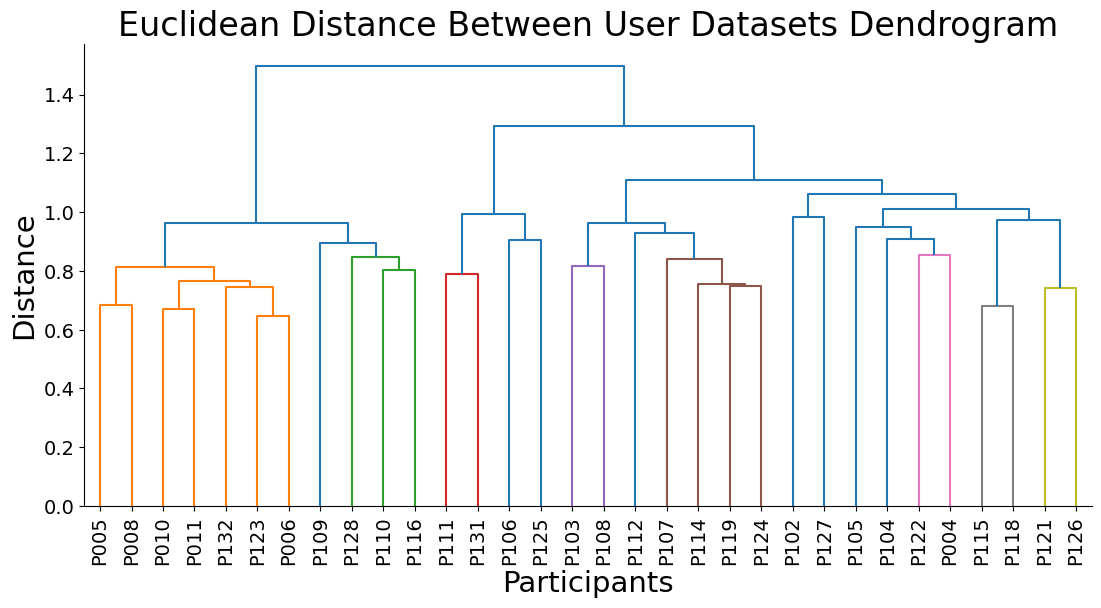

In [56]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cos, method='ward')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90, color_threshold=0.88)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Euclidean Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


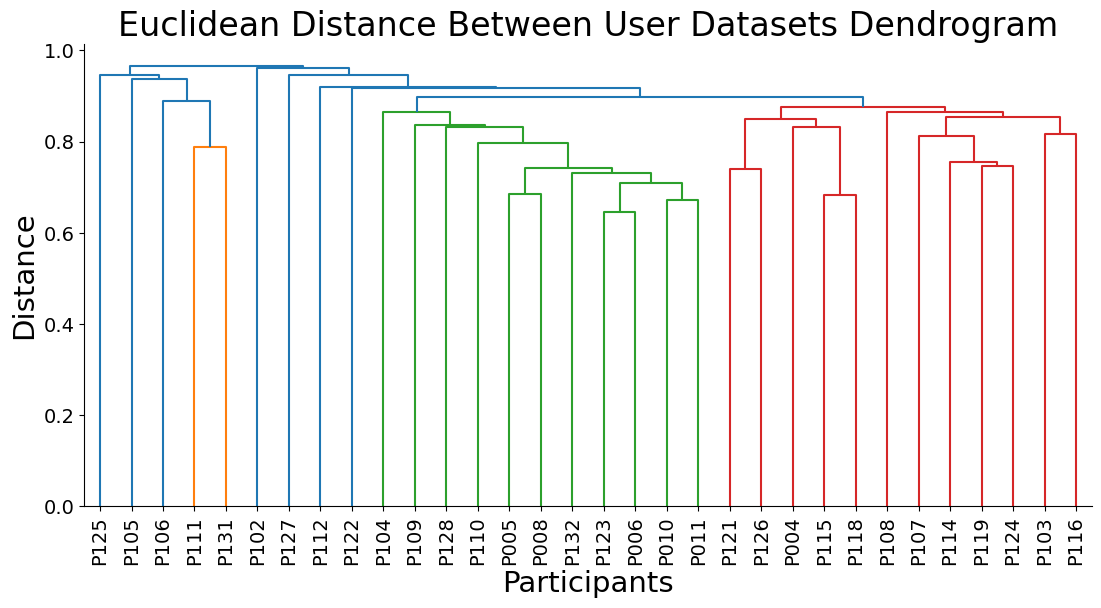

In [57]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cos, method='average')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90, color_threshold=0.88)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Euclidean Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


## Cosine Similarity

In [34]:
# Calculate inter-user distances using Euclidean distance
user_distances_cos = calculate_inter_user_distances(dataframes, distance_metric='cosine')
# Convert to a condensed distance matrix
condensed_distances_cos = squareform(user_distances_cos)

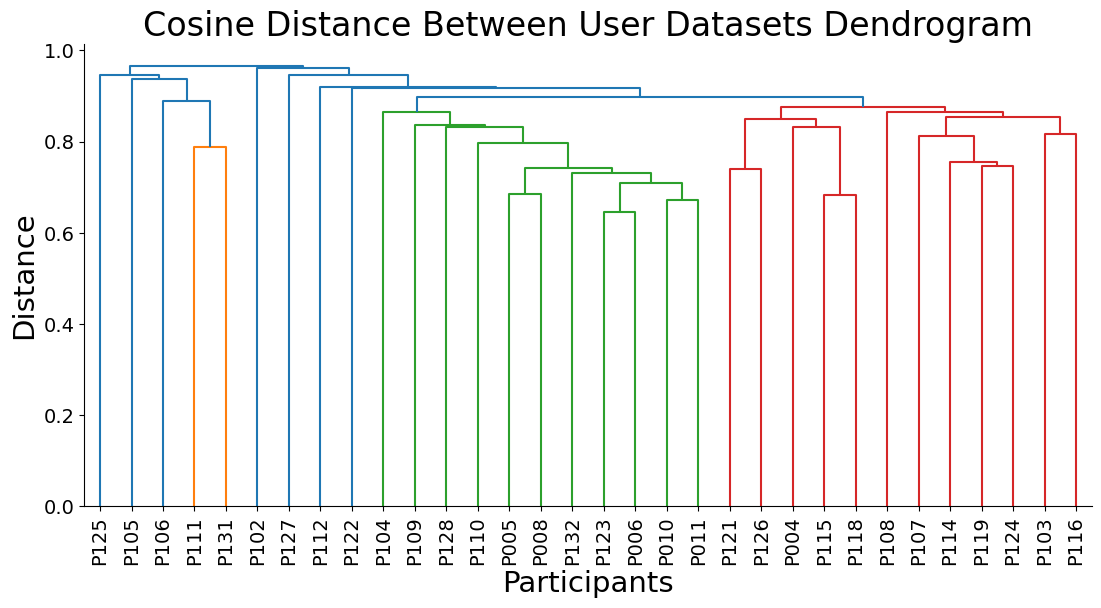

In [49]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cos, method='average')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90, color_threshold=0.88)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Cosine Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


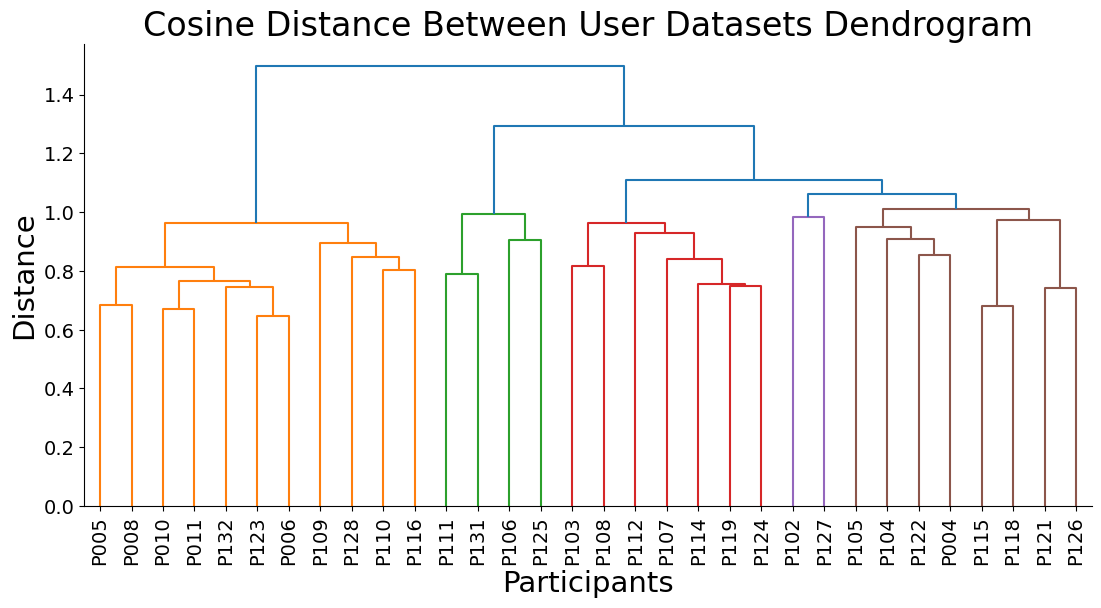

In [44]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cos, method='ward')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Cosine Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


## Correlation Distance

In [38]:
# Calculate inter-user distances using Euclidean distance
user_distances_cor = calculate_inter_user_distances(dataframes, distance_metric='correlation')
# Convert to a condensed distance matrix
condensed_distances_cor = squareform(user_distances_cor)

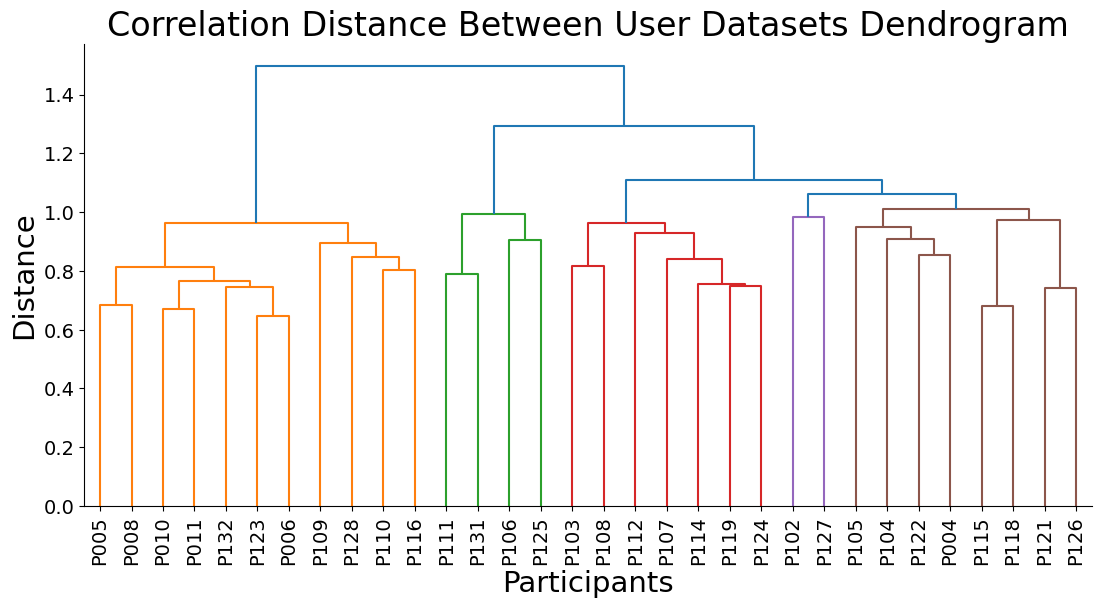

In [50]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cor, method='ward')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Correlation Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


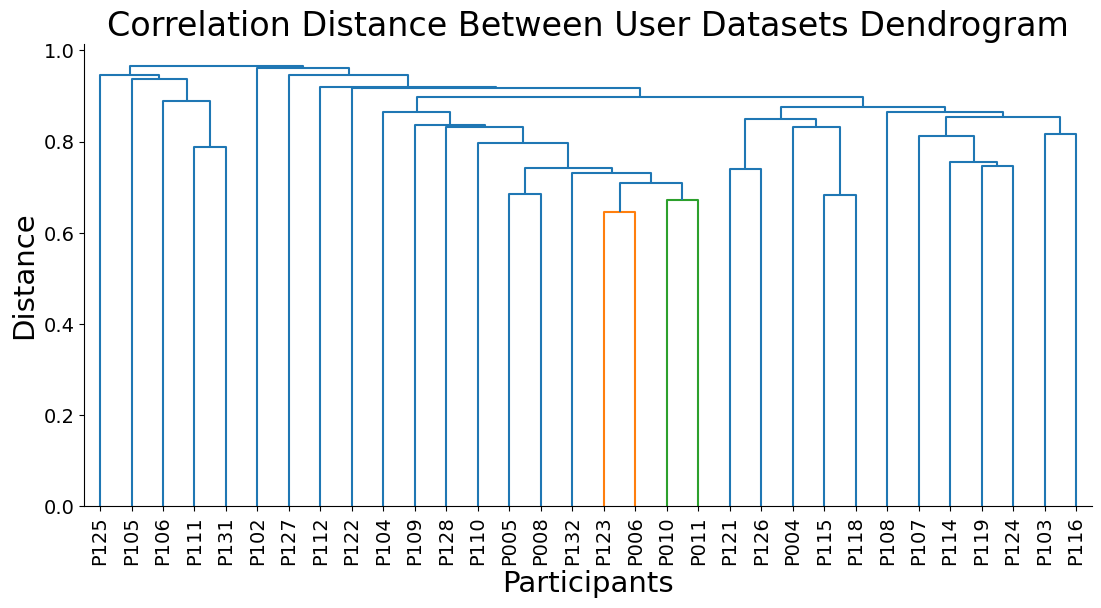

In [51]:
# Perform hierarchical clustering
Z = linkage(condensed_distances_cor, method='average')

# Plot dendrogram
plt.figure(figsize=(13, 6))
dendrogram(Z, labels=list(dataframes.keys()), leaf_font_size=16, leaf_rotation=90)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Correlation Distance Between User Datasets Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()
